In [1]:
import numpy as np
import pandas as pd
import sklearn
import glob
import os 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#getting data 

os.chdir("ETFs")

#create a dataframe of all of ETFs
etf_filenames = glob.glob("*.us.csv")
etf_dfs = []
index_of_exceptions = []
for i in range(len(etf_filenames)):
    try:
        etf_dfs.append(pd.read_csv(etf_filenames[i]))
    except:
        index_of_exceptions.append(i)
        pass
for i in index_of_exceptions:
    etf_filenames.pop(i)
#match etf data to its filename and create a column of ETFnames
for dataframe, filename in zip(etf_dfs, etf_filenames):
     dataframe["ETFName"] = filename.split(".us.csv")[0]
all_etfs = pd.concat(etf_dfs, ignore_index=True)

#OpenInt values are all 0 so get rid of them 
all_etfs = all_etfs.drop(['OpenInt'], axis = 1)
all_etfs.index = pd.to_datetime(all_etfs.Date)
all_etfs = all_etfs.drop(['Date'], axis = 1)
#Get DON close prices for the entire dataset, 30 day selection, 60 day selection, 90 day selection, 120 day selection
start_day = 2082
don_close = all_etfs[all_etfs.ETFName =='don'].Close
don_close_30 = all_etfs[all_etfs.ETFName =='don'].Close.iloc[start_day:start_day + 31]
don_close_60 = all_etfs[all_etfs.ETFName =='don'].Close.iloc[start_day:start_day + 61]
don_close_90 = all_etfs[all_etfs.ETFName =='don'].Close.iloc[start_day: start_day + 91]
don_close_120 = all_etfs[all_etfs.ETFName =='don'].Close.iloc[start_day: start_day + 121]


In [2]:
#Time series model first (ARIMA)
#make data stationary (further exploration of this in DONtimeseriesanalysis)
log_don_close = np.log(don_close)
log_diff_don_close = (log_don_close - log_don_close.shift()).dropna()
log_don_close_30 = np.log(don_close_30)
log_diff_don_close_30 = (log_don_close_30 - log_don_close_30.shift()).dropna()
log_don_close_60 = np.log(don_close_60)
log_diff_don_close_60 = (log_don_close_60 - log_don_close_60.shift()).dropna()
log_don_close_90 = np.log(don_close_90)
log_diff_don_close_90 = (log_don_close_90 - log_don_close_90.shift()).dropna()
log_don_close_120 = np.log(don_close_120)
log_diff_don_close_120 = (log_don_close_120 - log_don_close_120.shift()).dropna()


In [3]:
#Use ACF and PACF tests to determine parameters for ARIMA model 
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from pandas.tools.plotting import autocorrelation_plot
#I value (# of differences, d) is 1
d_all= 1
d_30 = 1
d_60 = 1
d_90 = 1 
d_120 = 1 
#compute the AR value for arima
acf_all = acf(log_diff_don_close)#goes to zero quickly so q = 0
q_all = 0
acf_30 = acf(log_diff_don_close_30)#goes to zero quickly so q = 0 
q_30 = 0
acf_60 = acf(log_diff_don_close_60)#goes to zero quickly so q = 0 
q_60 = 0
acf_90 = acf(log_diff_don_close_90)#goes to zero quickly so p = 0
q_90 = 0
acf_120 = acf(log_diff_don_close_120)#goes to zero quickly so p = 0
q_120 = 0

#compute MA value for arima 
pacf(log_diff_don_close)#goes to zero quickly so p = 0
p_all = 0
pacf_30 = acf(log_diff_don_close_30)#goes to zero quickly so p = 0
p_30 = 0
pacf_60 = acf(log_diff_don_close_60)#goes to zero quickly so p = 0
p_60 = 0
pacf_90 = acf(log_diff_don_close_90)#goes to zero quickly so p = 0
p_90 = 0 
pacf_120 = acf(log_diff_don_close_120)#goes to zero quickly so p = 0
p_120 = 0

7.1189861704747415
0.1181854919058088
0.477538350394214
0.06864945455672741
0.3302034923858614


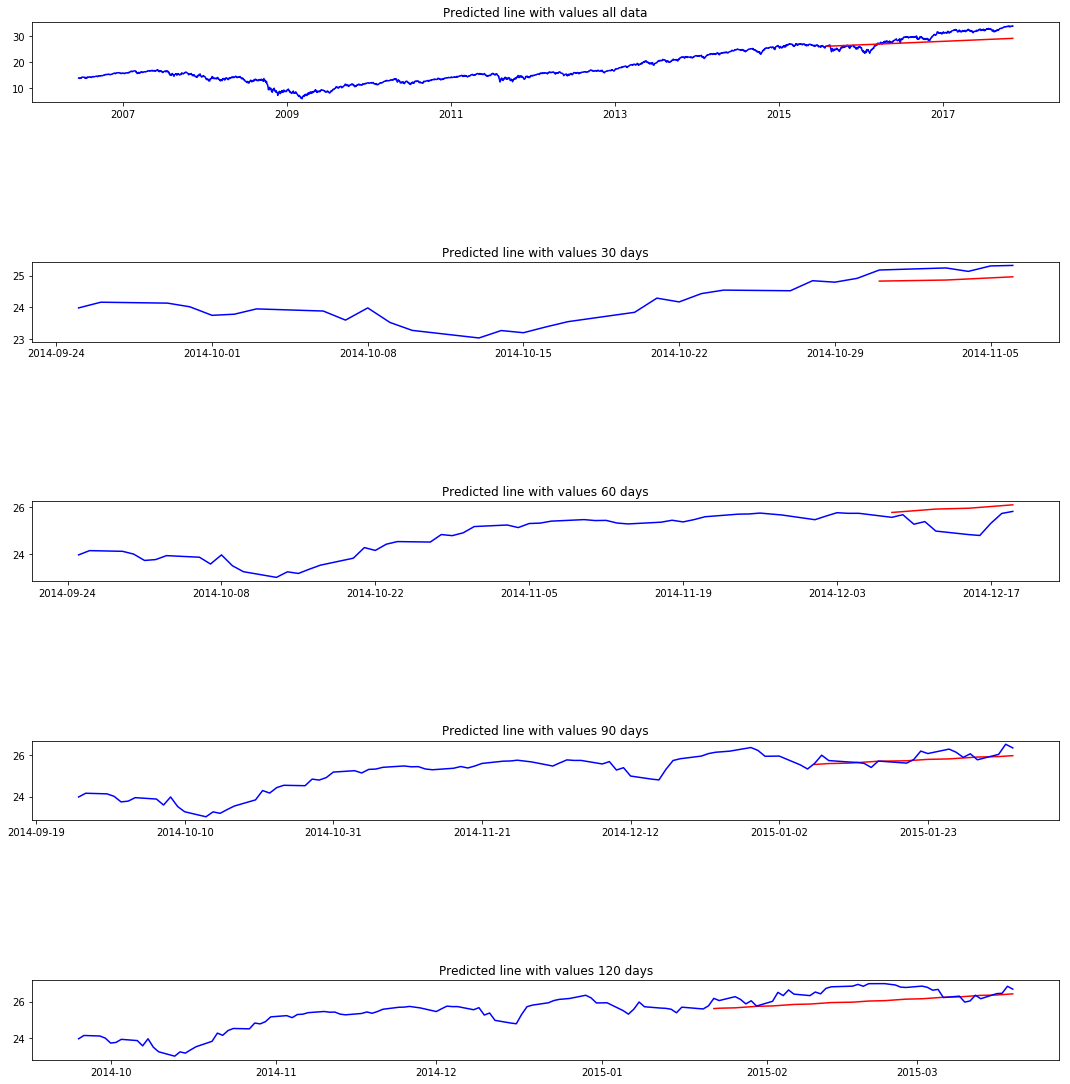

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
#predict 1/5 of the entire data
test_index = math.ceil(.8 * len(don_close))
X_train, X_test = don_close.iloc[:test_index], don_close.iloc[test_index:]
arima_model_all = ARIMA(X_train, order=(q_all,d_all,p_all))
fit_all = arima_model_all.fit(disp=0)
predicted_all = fit_all.forecast(steps = len(X_test))[0]
predicted_df_all = pd.DataFrame(predicted_all, X_test.index[:])
mse_all = mean_squared_error(X_test, predicted_all)
fig, modelplots = plt.subplots(5, 1,figsize=(15,15))
fig.tight_layout()
fig.subplots_adjust(hspace=2)
modelplots[0].plot(don_close, color = 'blue')
modelplots[0].plot(predicted_df_all, color = 'red')
modelplots[0].set_title('Predicted line with values all data')

#predict a single week (5 days) from 25 days (5 weeks)
arima_model_30 = ARIMA(don_close_30[:25], order = (q_30, d_30, p_30))
fit_30 = arima_model_30.fit(disp = 0)
predicted_30 = fit_30.forecast(steps = 5)[0]
predicted_df_30 = pd.DataFrame(predicted_30, don_close_30.index[26:])
mse_30 = mean_squared_error(don_close_30[26:], predicted_30)
modelplots[1].plot(predicted_df_30, color = 'red')
modelplots[1].plot(don_close_30, color = 'blue')
modelplots[1].set_title('Predicted line with values 30 days')
#predict two weeks (10 days) period from 50 (12 weeks)
arima_model_60 = ARIMA(don_close_60[:50], order =(q_60, d_60, p_60))
fit_60 = arima_model_60.fit(disp = 0)
predicted_60 = fit_60.forecast(steps = 10)[0]
predicted_df_60 = pd.DataFrame(predicted_60, don_close_60.index[51:])
mse_60 = mean_squared_error(don_close_60[51:], predicted_df_60)
modelplots[2].plot(predicted_df_60, color = 'red')
modelplots[2].plot(don_close_60, color = 'blue')
modelplots[2].set_title('Predicted line with values 60 days')

#predict four weeks (20 days) period from 70 days (14 weeks)
arima_model_90 = ARIMA(don_close_90[:70], order = (q_90, d_90, q_90))
fit_90 = arima_model_90.fit(disp = 0)
predicted_90 = fit_90.forecast(steps = 20)[0]
predicted_df_90 = pd.DataFrame(predicted_90, don_close_90.index[71:])
mse_90 = mean_squared_error(don_close_90[71:], predicted_df_90)
modelplots[3].plot(predicted_df_90, color = 'red')
modelplots[3].plot(don_close_90, color = 'blue')
modelplots[3].set_title('Predicted line with values 90 days')
#predict eight weeks (40 days) period from 80 days (16 weeks)
arima_model_120 = ARIMA(don_close_120[:80], order = (q_120, d_120, q_120))
fit_120 = arima_model_120.fit(disp = 0)
predicted_120 = fit_120.forecast(steps = 40)[0]
predicted_df_120 = pd.DataFrame(predicted_120, don_close_120.index[81:])
mse_120 =  mean_squared_error(don_close_120[81:], predicted_df_120)
modelplots[4].plot(predicted_df_120, color = 'red')
modelplots[4].plot(don_close_120, color = 'blue')
modelplots[4].set_title('Predicted line with values 120 days')

print(mse_all)
print(mse_30)
print(mse_60)
print(mse_90)
print(mse_120)

In [5]:
#SVM prediction
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
don_all = all_etfs[all_etfs.ETFName =='don'].drop(['Close', 'ETFName', 'High', 'Low'], axis = 1)
scaler = StandardScaler()
x_norm = scaler.fit_transform(don_all.values)
x_norm = pd.DataFrame(x_norm, index=don_all.index, columns=don_all.columns)
X_train, X_test, y_train, y_test = train_test_split(x_norm, don_close, test_size=.2, shuffle=False)
model = SVR(kernel = 'linear')
model_fit = model.fit(X_train, y_train.values.reshape(-1, 1))
model_prediction = model_fit.predict(X_test)
predicted_df = pd.DataFrame(model_prediction, index = y_test.index)


0.03100631561981961

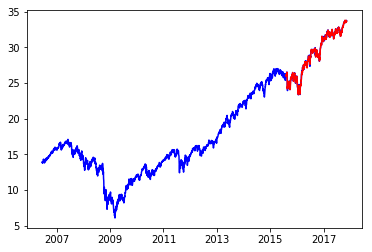

In [6]:
plt.subplot()
plt.plot(don_close, color = 'blue', label = 'open' )
plt.plot(predicted_df, color = 'red', label = 'open')
mean_squared_error(y_test, model_prediction)

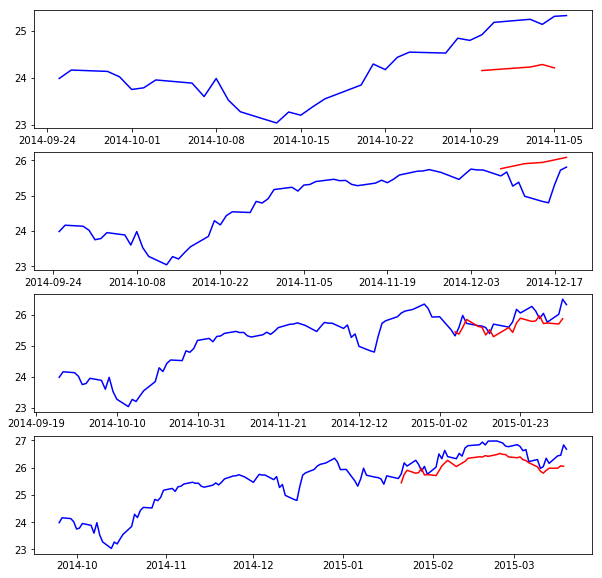

In [7]:
fig.tight_layout()
fig.subplots_adjust(hspace=2)
fig, predictplots = plt.subplots(4, 1,figsize=(10,10))
#30 days
X_train_30, X_test_30, y_train_30, y_test_30 = x_norm[start_day:start_day + 25], x_norm[start_day+25:start_day + 30],don_close[start_day:start_day + 25], don_close[start_day+25:start_day + 30]
model_30 = SVR(kernel = 'linear')
model_fit_30 = model.fit(X_train_30, y_train_30.values.reshape(-1, 1))
model_predict_30 = model_fit_30.predict(X_test_30)
predicted_df_30 = pd.DataFrame(model_predict_30, index = y_test_30.index)
predictplots[0].plot(don_close_30, color = 'blue', label = 'open')
predictplots[0].plot(predicted_df_30, color = 'red', label = 'open')
# mse_30_svm = 
#60 days
X_train_60, X_test_60, y_train_60, y_test_60 = x_norm[start_day:start_day + 50], x_norm[start_day+50:start_day + 60],don_close[start_day:start_day + 50], don_close[start_day+50:start_day + 60]
model_60 = SVR(kernel = 'linear')
model_fit_60 = model.fit(X_train_60, y_train_60.values.reshape(-1, 1))
model_predict_60 = model_fit_30.predict(X_test_60)
predicted_df_30 = pd.DataFrame(model_predict_60, index = y_test_60.index)
predictplots[1].plot(don_close_60, color = 'blue', label = 'open')
predictplots[1].plot(predicted_df_60, color = 'red', label = 'open')
#90 days
X_train_90, X_test_90, y_train_90, y_test_90 = x_norm[start_day:start_day + 70], x_norm[start_day+70:start_day + 90],don_close[start_day:start_day + 70], don_close[start_day+70:start_day + 90]
model_90 = SVR(kernel = 'linear')
model_fit_90 = model.fit(X_train_90, y_train_90.values.reshape(-1, 1))
model_predict_90 = model_fit_90.predict(X_test_90)
predicted_df_90 = pd.DataFrame(model_predict_90, index = y_test_90.index)
predictplots[2].plot(don_close_90, color = 'blue', label = 'open')
predictplots[2].plot(predicted_df_90, color = 'red', label = 'open')
#120 days
X_train_120, X_test_120, y_train_120, y_test_120 = x_norm[start_day:start_day + 80], x_norm[start_day+80:start_day + 120],don_close[start_day:start_day + 80], don_close[start_day+80:start_day + 120]
model_120 = SVR(kernel = 'linear')
model_fit_120 = model.fit(X_train_120, y_train_120.values.reshape(-1, 1))
model_predict_120 = model_fit_120.predict(X_test_120)
predicted_df_120 = pd.DataFrame(model_predict_120, index = y_test_120.index)
predictplots[3].plot(don_close_120, color = 'blue', label = 'open')
predictplots[3].plot(predicted_df_120, color = 'red', label = 'open')

